In [1]:
# Import dependencies 
import pandas as pd
import pymongo
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf


# Data pull and pre-processing

In [ ]:
# Import Census CSV data 
census_data = pd.read_csv('./Resources/2016_2020_census_data.csv')
census_data

In [ ]:
# Perform some data cleansing options Drop NA
census_data.dropna(inplace=True)
census_data

In [ ]:
cleaned_census_data = census_data[census_data['Household Income']>0]
cleaned_census_data

In [ ]:
# Convert years to time since current 
cleaned_census_data['Years Since'] = cleaned_census_data['Year'].map({2016: 7, 2020: 3})
cleaned_census_data

In [ ]:
zip_codes = pd.read_csv('./Resources/usazipcode.csv')
zip_codes.columns

In [ ]:
zip_codes.dropna(inplace=True)
zip_codes['zip'] = zip_codes['zip'].astype(int)
zip_codes.dtypes

In [ ]:
# Merge the census data and zipcode DF
new_df = pd.merge(cleaned_census_data, zip_codes, how='left', left_on='Zipcode', right_on = 'zip')
new_df.head()

In [ ]:
# Merge the census and zip data 
census_zip_df = new_df.drop(['zip', 'Zipcode name', 'City', 'County Name'],axis=1)
census_zip_df

In [ ]:
# Import the winner values by state
election_results = pd.read_csv('./Resources/2016_2020_winners.csv')
election_results

In [ ]:
election_results.columns

In [ ]:
# Merge the winner info with the previosuly established DF
next_df = pd.merge(census_zip_df, election_results, how='left', left_on=['State','Year'], right_on = ['STATE','Year'])
next_df.head()

In [ ]:
# Create the final dataset for ML application
db_data = next_df.drop(['Year','STATE', 'Electoral Vote (D)', 'Electoral Vote (R)', 'Popular Vote (D)',
       'Popular Vote (R)', 'Popular Vote All Others', 'Total Vote'], axis=1)
db_data

In [ ]:
# last drop of NA values 
db_data.dropna(inplace=True)
db_data

In [2]:
# Initialize PyMongo to work with MongoDBs
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

In [3]:
# Export data to MongoDB
electiondb = client.election_db
collection = electiondb.election_data
data_dict = db_data.to_dict("records")
collection.insert_many(data_dict)

In [ ]:
#electiondb.election_data.drop()

In [ ]:
# creating a DB that has the electoral vote listed
db_electoralVote = next_df.drop(['Year','STATE', 'Popular Vote (D)',
       'Popular Vote (R)', 'Popular Vote All Others', 'Total Vote'], axis=1)


In [ ]:
# Replacing NaN with Zeros
db_electoralVote[['Electoral Vote (D)', 'Electoral Vote (R)']] = db_electoralVote[['Electoral Vote (D)', 'Electoral Vote (R)']].fillna(0)
db_electoralVote

In [ ]:
db_electoralVote.dropna(inplace=True)
db_electoralVote

In [ ]:
# Export data with electoral vote to MongoDB
electiondb = client.election_db
collection = electiondb.electoral_data
data_dict = db_electoralVote.to_dict("records")
collection.insert_many(data_dict)

In [ ]:
#electiondb.electoral_data.drop()

# Import data from DB for modeling

In [4]:
results = electiondb.election_data.find()
cluster_data = []
for result in results:
    del result['_id']
    cluster_data.append(result)

In [5]:
cluster_data = pd.DataFrame(cluster_data)
cluster_data

,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Years Since,State,Winner
0,5762,513,39.2,58558,24235.0,50,9.746589,7,VT,Republican
1,5763,2715,43.9,54968,29674.0,488,17.974217,7,VT,Republican
2,5764,3370,41.3,44468,22651.0,323,9.584570,7,VT,Republican
3,5765,1632,46.7,56771,30786.0,85,5.208333,7,VT,Republican
4,5766,598,45.9,52250,33227.0,76,12.709030,7,VT,Republican
...,...,...,...,...,...,...,...,...,...,...
119617,16623,552,54.9,51667,26369.0,80,14.492754,3,PA,Democrat
119618,16627,2118,44.6,45000,24699.0,324,15.297450,3,PA,Democrat
119619,16634,315,46.1,51500,25084.0,24,7.619048,3,PA,Democrat
119620,16640,707,48.6,55982,28335.0,167,23.620934,3,PA,Democrat


# Building K-Means Cluster Model

In [6]:
# Initial imports
import pandas as pd
from sklearn.cluster import KMeans
from pathlib import Path
import matplotlib.pyplot as plt

In [7]:
cluster_data = cluster_data.drop(columns=['Zipcode','State'],axis=1)
cluster_data

,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Years Since,Winner
0,513,39.2,58558,24235.0,50,9.746589,7,Republican
1,2715,43.9,54968,29674.0,488,17.974217,7,Republican
2,3370,41.3,44468,22651.0,323,9.584570,7,Republican
3,1632,46.7,56771,30786.0,85,5.208333,7,Republican
4,598,45.9,52250,33227.0,76,12.709030,7,Republican
...,...,...,...,...,...,...,...,...
119617,552,54.9,51667,26369.0,80,14.492754,3,Democrat
119618,2118,44.6,45000,24699.0,324,15.297450,3,Democrat
119619,315,46.1,51500,25084.0,24,7.619048,3,Democrat
119620,707,48.6,55982,28335.0,167,23.620934,3,Democrat


In [8]:
cluster_data_cat = cluster_data.dtypes[cluster_data.dtypes == "object"].index.tolist()
cluster_data[cluster_data_cat].nunique()

Winner    2
dtype: int64

In [11]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(cluster_data[cluster_data_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(cluster_data_cat)
encode_df.head()

C:\Users\huntl\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Winner_Democrat,Winner_Republican
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


In [12]:
# Merge one-hot encoded features and drop the originals
cluster_data = cluster_data.merge(encode_df,left_index=True, right_index=True)
cluster_data = cluster_data.drop(cluster_data_cat,1)
cluster_data.head()

C:\Users\huntl\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Years Since,Winner_Democrat,Winner_Republican
0,513,39.2,58558,24235.0,50,9.746589,7,0.0,1.0
1,2715,43.9,54968,29674.0,488,17.974217,7,0.0,1.0
2,3370,41.3,44468,22651.0,323,9.584570,7,0.0,1.0
3,1632,46.7,56771,30786.0,85,5.208333,7,0.0,1.0
4,598,45.9,52250,33227.0,76,12.709030,7,0.0,1.0


In [13]:
kcluster_data = cluster_data[cluster_data['Years Since'] == 7]
kcluster_data = kcluster_data.drop('Winner_Democrat', axis=1)

In [14]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(kcluster_data)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow

,k,inertia
0,1,5.503562e+13
1,2,3.164954e+13
2,3,2.382582e+13
3,4,1.755667e+13
4,5,1.427179e+13
5,6,1.257885e+13
6,7,1.107385e+13
7,8,9.958006e+12
8,9,9.086040e+12
9,10,8.404441e+12


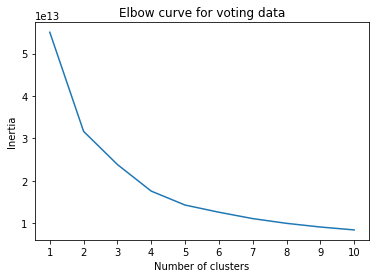

In [15]:
# Plot the elbow curve to find the best candidate(s) for k
plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve for voting data')
plt.show()

In [16]:
def get_clusters(k, data):
    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Train the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_

    return data

In [21]:
clusters = get_clusters(2, kcluster_data)
clusters

,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Years Since,Winner_Republican,class
0,513,39.2,58558,24235.0,50,9.746589,7,1.0,1
1,2715,43.9,54968,29674.0,488,17.974217,7,1.0,1
2,3370,41.3,44468,22651.0,323,9.584570,7,1.0,1
3,1632,46.7,56771,30786.0,85,5.208333,7,1.0,1
4,598,45.9,52250,33227.0,76,12.709030,7,1.0,1
...,...,...,...,...,...,...,...,...,...
90443,17226,35.9,73660,38860.0,1411,8.191106,7,0.0,0
90444,9872,36.4,82119,43211.0,478,4.841977,7,0.0,0
90445,286,62.3,100755,50354.0,9,3.146853,7,0.0,0
90446,122,29.9,75000,24629.0,45,36.885246,7,0.0,1


In [22]:
def show_clusters(df):
    plt.scatter(df['Median Age'], df['Per Capita Income'], c=df['class'])
    plt.xlabel('Median Age')
    plt.ylabel('Per Capita Income')
    plt.show()

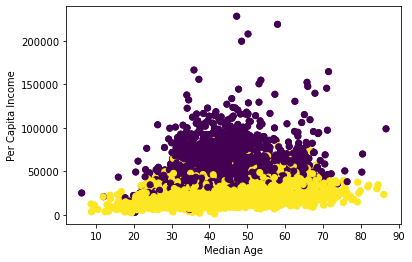

In [23]:
show_clusters(clusters)

# Neural Network Model

In [25]:
cluster_data.head()

,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Years Since,Winner_Democrat,Winner_Republican
0,513,39.2,58558,24235.0,50,9.746589,7,0.0,1.0
1,2715,43.9,54968,29674.0,488,17.974217,7,0.0,1.0
2,3370,41.3,44468,22651.0,323,9.584570,7,0.0,1.0
3,1632,46.7,56771,30786.0,85,5.208333,7,0.0,1.0
4,598,45.9,52250,33227.0,76,12.709030,7,0.0,1.0


In [26]:
nn_model = cluster_data[cluster_data['Years Since'] == 7]
nn_model

,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Years Since,Winner_Democrat,Winner_Republican
0,513,39.2,58558,24235.0,50,9.746589,7,0.0,1.0
1,2715,43.9,54968,29674.0,488,17.974217,7,0.0,1.0
2,3370,41.3,44468,22651.0,323,9.584570,7,0.0,1.0
3,1632,46.7,56771,30786.0,85,5.208333,7,0.0,1.0
4,598,45.9,52250,33227.0,76,12.709030,7,0.0,1.0
...,...,...,...,...,...,...,...,...,...
90443,17226,35.9,73660,38860.0,1411,8.191106,7,1.0,0.0
90444,9872,36.4,82119,43211.0,478,4.841977,7,1.0,0.0
90445,286,62.3,100755,50354.0,9,3.146853,7,1.0,0.0
90446,122,29.9,75000,24629.0,45,36.885246,7,1.0,0.0


In [27]:
# Split our preprocessed data into our features and target arrays In this case Republican winner is the target
y = nn_model['Winner_Republican'].values
X = nn_model.drop(columns=['Winner_Republican','Winner_Democrat'], axis=1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)

In [28]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [76]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  8
hidden_nodes_layer2 =  5
hidden_nodes_layer3 =  3

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, activation="relu", input_dim=number_input_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 8)                 64        
                                                                 
 dense_20 (Dense)            (None, 5)                 45        
                                                                 
 dense_21 (Dense)            (None, 3)                 18        
                                                                 
 dense_22 (Dense)            (None, 1)                 4         
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [77]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [78]:
# Create a callback that saves the model's weights every five epochs
import os 
from tensorflow.keras.callbacks import ModelCheckpoint

os.makedirs('check_points/', exist_ok=True)
path = 'check_points/weights.{epoch:02d}.hdf5'

cp_callback = ModelCheckpoint(filepath = path, save_weights_only = True, save_freq = 5)

In [79]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=35, callbacks= [cp_callback])

Epoch 1/35
1437/1437 [==============================] - 6s 4ms/step - loss: 0.6040 - accuracy: 0.6916
Epoch 2/35
1437/1437 [==============================] - 8s 5ms/step - loss: 0.5876 - accuracy: 0.7011
Epoch 3/35
1437/1437 [==============================] - 7s 5ms/step - loss: 0.5848 - accuracy: 0.7023
Epoch 4/35
1437/1437 [==============================] - 7s 5ms/step - loss: 0.5834 - accuracy: 0.7043
Epoch 5/35
1437/1437 [==============================] - 6s 4ms/step - loss: 0.5823 - accuracy: 0.7055
Epoch 6/35
1437/1437 [==============================] - 7s 5ms/step - loss: 0.5816 - accuracy: 0.7049
Epoch 7/35
1437/1437 [==============================] - 7s 5ms/step - loss: 0.5810 - accuracy: 0.7057
Epoch 8/35
1437/1437 [==============================] - 8s 5ms/step - loss: 0.5804 - accuracy: 0.7059
Epoch 9/35
1437/1437 [==============================] - 6s 4ms/step - loss: 0.5802 - accuracy: 0.7066
Epoch 10/35
1437/1437 [==============================] - 7s 5ms/step - loss: 0.580

In [80]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

479/479 - 1s - loss: 0.5790 - accuracy: 0.7029 - 559ms/epoch - 1ms/step
Loss: 0.5790468454360962, Accuracy: 0.7028526663780212


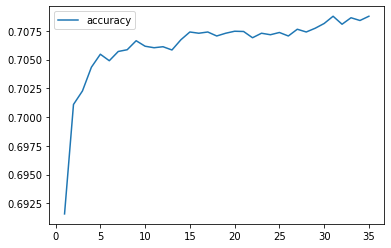

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.DataFrame(fit_model.history)

df.index+=1 

df.plot(y='accuracy')
plt.show()

# PCA

In [82]:
cluster_data.head()

,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Years Since,Winner_Democrat,Winner_Republican
0,513,39.2,58558,24235.0,50,9.746589,7,0.0,1.0
1,2715,43.9,54968,29674.0,488,17.974217,7,0.0,1.0
2,3370,41.3,44468,22651.0,323,9.584570,7,0.0,1.0
3,1632,46.7,56771,30786.0,85,5.208333,7,0.0,1.0
4,598,45.9,52250,33227.0,76,12.709030,7,0.0,1.0


In [83]:
pca_data = cluster_data[cluster_data['Years Since']==7]
#pca_data = pca_data.drop(columns=['Zipcode'],axis=1)
pca_scaled = StandardScaler().fit_transform(pca_data)

In [84]:
# Initialize PCA model for 3 principal components
from sklearn.decomposition import PCA
pca = PCA(n_components=.90)

# Get two principal components for the iris data.
vote_pca = pca.fit_transform(pca_scaled)

In [85]:
# Transform PCA data to a DataFrame
df_pca_data = pd.DataFrame(
    data = vote_pca,
)
df_pca_data.head()

,0,1,2,3
0,1.190890,0.098663,-1.535115,-0.819682
1,1.065947,0.202340,-1.689756,-0.120904
2,0.870646,0.152552,-1.746555,-0.381881
3,1.760218,-0.287371,-1.339934,0.065765
4,1.431326,-0.164721,-1.581227,0.044342


In [86]:
# Fetch the explained variance
total = pca.explained_variance_ratio_
sum(total)

0.9058639819733759

# 4 components provide 90% of the infomration in this data set

In [87]:
inertia = []
k = list(range(1, 10))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(df_pca_data)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow

,k,inertia
0,1,444047.277051
1,2,308731.849907
2,3,239198.669195
3,4,197396.375340
4,5,168745.730430
5,6,152408.669652
6,7,139222.155258
7,8,126758.517842
8,9,116501.955609


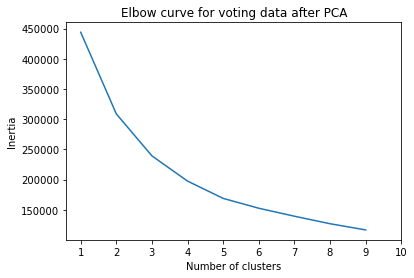

In [88]:
# Plot the elbow curve to find the best candidate(s) for k
plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve for voting data after PCA')
plt.show()

# 

In [ ]:
# Get predictions
# predictions = model.predict()
# print(predictions)